# 03 - EDA

In [1]:
import sys
sys.executable

'/usr/local/bin/python'

## Imports

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import constants as cnst
import stock_utils as su

pd.set_option('display.max_columns', None)

NSE_DATA_DIR = PosixPath('../data/NSE') | Valid: True
SCREENER_EPS_DATA_DIR = PosixPath('../data/Screener.in/EPS') | Valid: True
PROCESSED_DATA_DIR = PosixPath('../data/processed') | Valid: True


## Constants

In [3]:
stock_symbols = su.get_all_stock_symbols(
    cnst.NSE_DATA_DIR
)

stock_symbols

['DEEPAKFERT', 'HDFCBANK', 'INDIGOPNTS', 'ITBEES', 'JUBLFOOD']

In [4]:
STOCK_SYMBOL = stock_symbols[1]

STOCK_SYMBOL

'HDFCBANK'

## Data loading

### Stock data

In [5]:
stock_data = su.StockData(STOCK_SYMBOL)
stock_data

Symbol: HDFCBANK
Total records: 1049
First record: 2020-01-01
Last record: 2024-02-26

## Statistical analysis

### Historical

#### Candle type

##### Overall proportion

In [6]:
stock_data.processed['IsGreen'].value_counts(normalize = True).mul(100).round(2)

IsGreen
0    51.0
1    49.0
Name: proportion, dtype: float64

##### By year

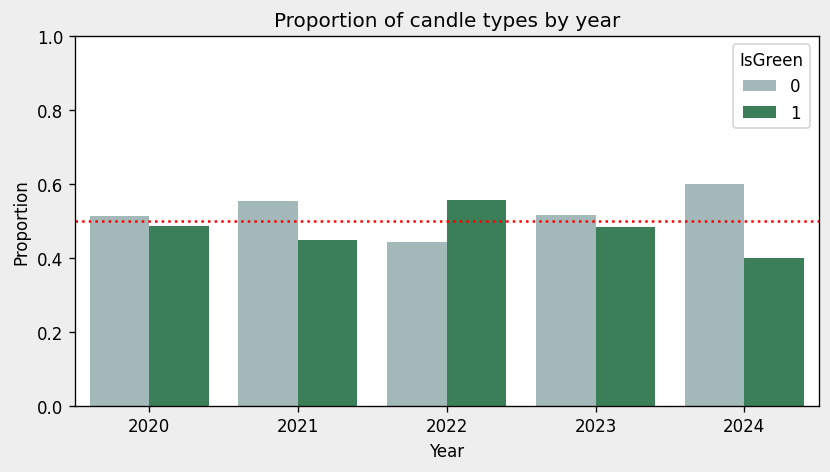

In [7]:
plt.figure(figsize = (8, 4), dpi = 120, facecolor = "#eee")
sns.barplot(
    data = stock_data.processed.groupby(
        'Year', as_index = False
    )['IsGreen'].value_counts(normalize = True),
    x = "Year",
    y = "proportion",
    hue = "IsGreen",
    palette = "blend:#9fbcbb,seagreen"
)
plt.hlines(y = 0.5, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.ylim((0, 1))
plt.xlim((
    -0.5, 
    stock_data.processed['Year'].max() - stock_data.processed['Year'].min() + 0.5
))
plt.ylabel("Proportion")
plt.title("Proportion of candle types by year")
plt.show()

##### By quarter

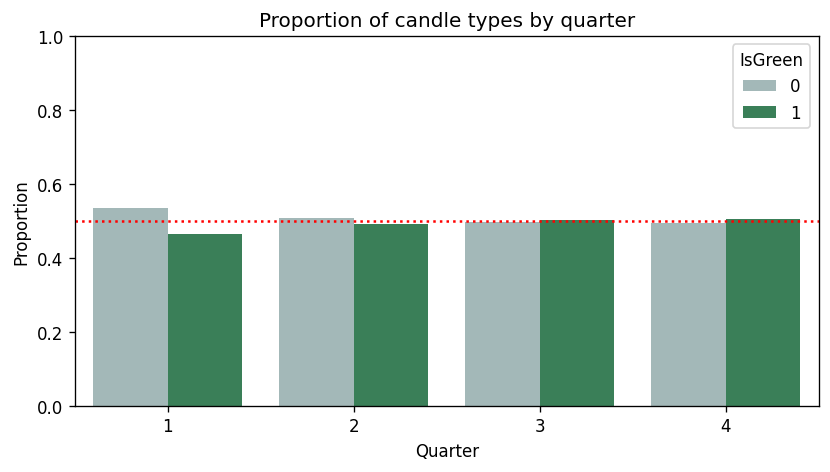

In [8]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.barplot(
    data = stock_data.processed.groupby(
        'Quarter', as_index = False
    )['IsGreen'].value_counts(normalize = True),
    x = "Quarter",
    y = "proportion",
    hue = "IsGreen",
    palette = "blend:#9fbcbb,seagreen"
)
plt.hlines(y = 0.5, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.ylim((0, 1))
plt.xlim((-0.5, 3.5))
plt.ylabel("Proportion")
plt.title("Proportion of candle types by quarter")
plt.show()

#### Normalized Range

##### Overall distribution

In [9]:
stock_data.processed['NR'] = (
    (
        stock_data.processed['Close'] - stock_data.processed['Open']
    ) / stock_data.processed['Open']
) * 100

stock_data.processed[['NR']].describe().round(2)

,NR
count,1049.00
mean,-0.05
std,1.51
min,-10.97
25%,-0.77
50%,-0.02
75%,0.66
max,11.20


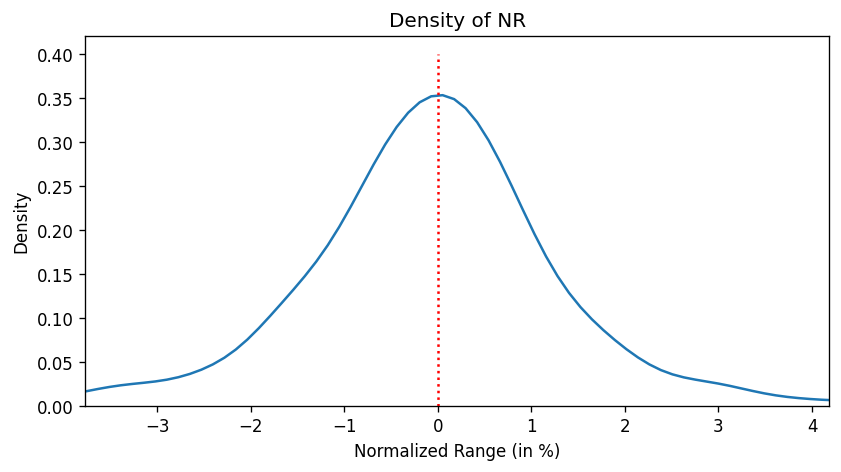

In [10]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.kdeplot(
    stock_data.processed['NR']
)
plt.vlines(x = 0, ymin = 0, ymax = 0.4, linestyles = "dotted", colors = "red")
plt.xlabel("Normalized Range (in %)")
plt.title("Density of NR")
plt.xlim((
    stock_data.processed['NR'].quantile(0.01),
    stock_data.processed['NR'].quantile(0.99)
))
plt.show()

##### By candle type

In [11]:
stock_data.processed.groupby('IsGreen')[['NR']].describe().round(2)

NR                                           
         count  mean   std    min   25%   50%   75%   max
IsGreen                                                  
0        535.0 -1.06  1.06 -10.97 -1.48 -0.76 -0.34  -0.0
1        514.0  1.01  1.13   0.00  0.32  0.69  1.31  11.2

##### By year

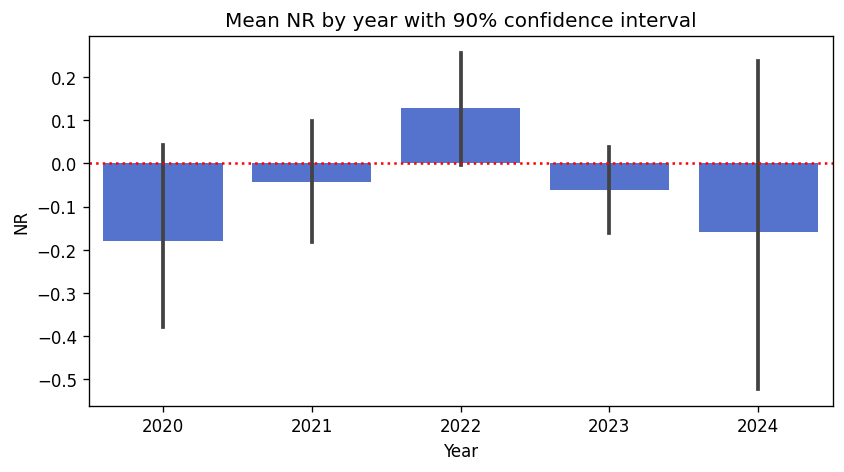

In [12]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.barplot(
    data = stock_data.processed,
    x = "Year",
    y = "NR",
    estimator = "mean",
    errorbar = ("ci", 90),
    color = "royalblue"
)
plt.hlines(y = 0, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.title(r"Mean NR by year with 90% confidence interval")
plt.xlim((
    -0.5, 
    stock_data.processed['Year'].max() - stock_data.processed['Year'].min() + 0.5
))
plt.show()

##### By quarter

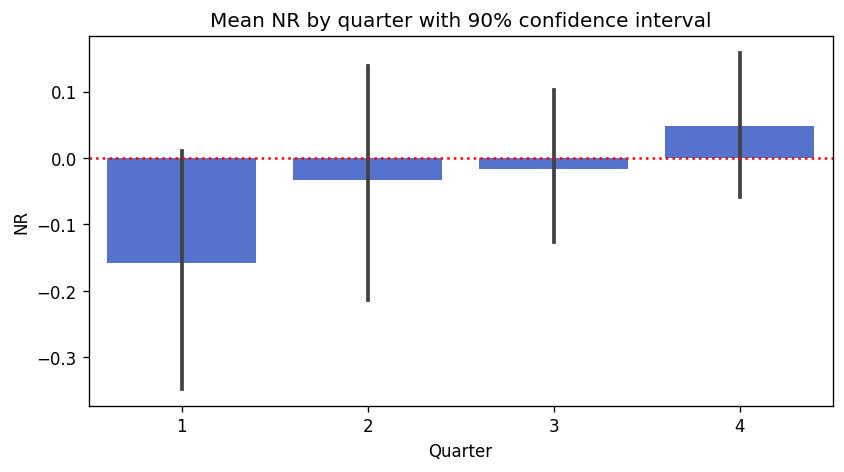

In [13]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.barplot(
    data = stock_data.processed,
    x = "Quarter",
    y = "NR",
    estimator = "mean",
    errorbar = ("ci", 90),
    color = "royalblue"
)
plt.hlines(y = 0, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.title(r"Mean NR by quarter with 90% confidence interval")
plt.xlim((-0.5, 3.5))
plt.show()

### Current

#### First hit of current price

In [14]:
stock_data.get_first_hit(
    stock_data.processed.iloc[-1]["Close"]
)

Target: 1422.3
First hit: 2020-11-24 | 1189 days ago
'Close' at first hit: 1438.2
Total hits: 664


### Trends

#### Stock Close Price

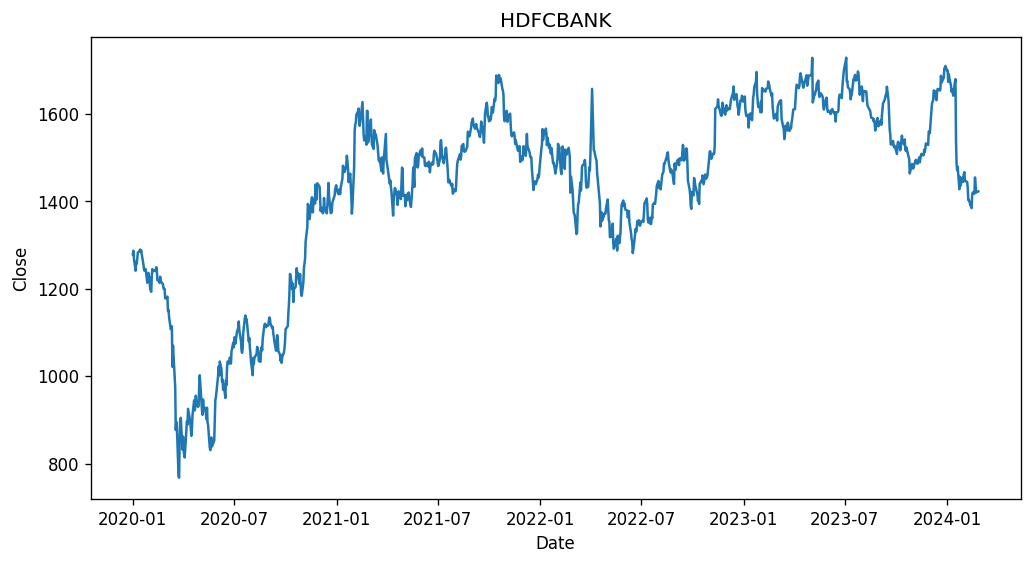

In [15]:
plt.figure(figsize = (10, 5), dpi = 120)
sns.lineplot(
    data = stock_data.processed,
    x = "Date",
    y = "Close"
)
plt.title(STOCK_SYMBOL)
plt.show()

#### PE

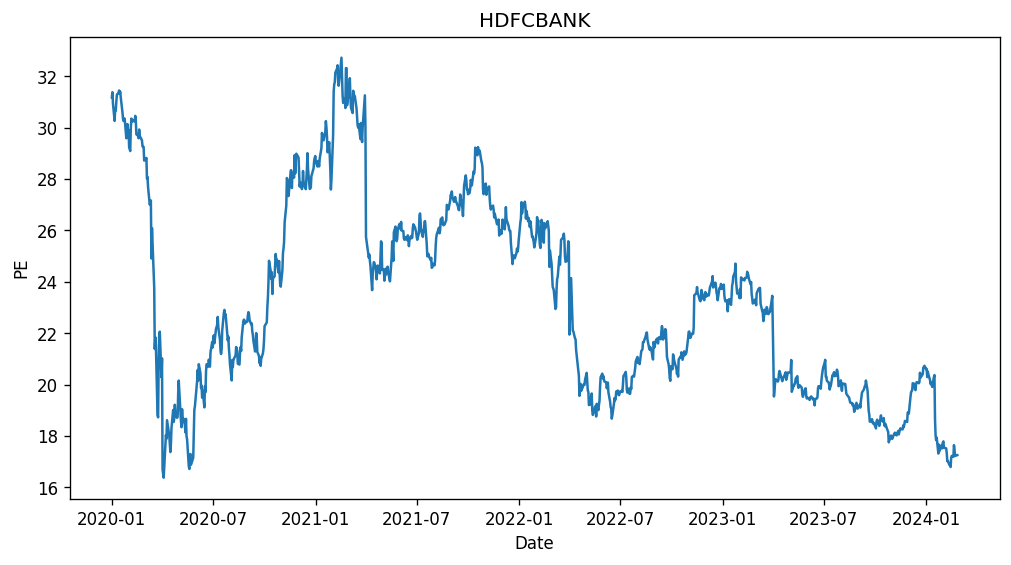

In [16]:
if "PE" in stock_data.processed.columns:
    plt.figure(figsize = (10, 5), dpi = 120)
    sns.lineplot(
        data = stock_data.processed,
        x = "Date",
        y = "PE"
    )
    plt.title(STOCK_SYMBOL)
    plt.show()
else:
    print("PE data not available")